In [24]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

filename = "output/msource_value_dic_12-25-2022-16-32-41.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),

#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

In [25]:
if 'pol_dic' in output_obj: 
    output_obj['pol_dic']
    action = eval_policy_from_policy_dic(sourcingEnv2, pol_dic = output_obj['pol_dic'])
    action

# sourcingEnv2.lambda_arrival = 10
# sourcingEnv2.procurement_cost_vec = np.array([4.5, 0.05])

In [26]:
sourcingEnv2.lambda_arrival

5

In [27]:
model_params["branch_name"], model_params["git_commit"]

('larkin/supp-inc-unif-adp', 'cde6cd1c86fc153ec2bb8f7a46fc7c28c5adbb15')

In [28]:
# sourcingEnv2.lambda_arrival = 100
kwargs = {"periods" : 60,
    "nested_mc_iters" : 5,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty" : model_params['policy_params']['b_penalty'],
    "supplier_index": 1,
    "h_cost": 2,
    "b_penalty": 10
}

In [29]:
dummy_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        periods = 100,
        nested_mc_iters = 30,
        big_s = model_params['policy_params']['big_s'],
        small_s = model_params['policy_params']['small_s'],
        h_cost = model_params['policy_params']['h_cost'],
        b_penalty = model_params['policy_params']['b_penalty'],
        max_order = 6, # BIG_S,
        policy_callback=dummy_explore_policy,
        use_tqdm = True
    )

print(np.mean(dummy_cost))
print(np.median(np.array(dummy_cost)))
print(np.std(np.array(dummy_cost)))

100%|██████████| 30/30 [00:01<00:00, 16.66it/s]

3.366820959034334
3.146505041595315
0.7176951837115079


In [30]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = BIG_S,
    policy_callback=dual_index_policy,
    use_tqdm = True
)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

100%|██████████| 30/30 [00:35<00:00,  1.20s/it]

2.6070331290001163
2.3605680317043314
0.9070282290325473


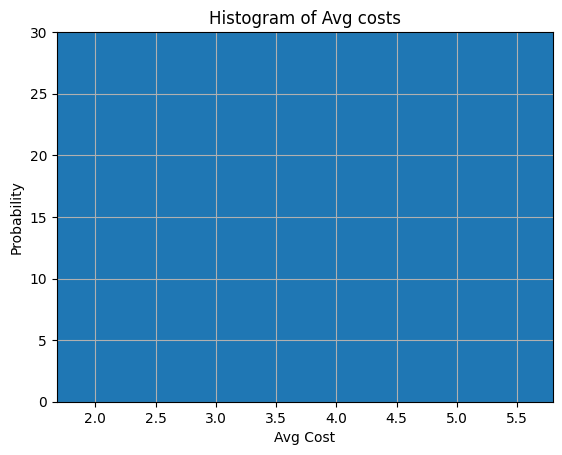

In [31]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange( np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [32]:
# sourcingEnv2.lambda_arrival = 50
# sourcingEnv2.supplier_lead_times_vec = np.array([0.008, 0.04])

model_params['mdp_env_params']

{'lambda': 5,
 'max_inven': 30,
 'action_size': 3,
 'discount_fac': 1.0,
 'procurement_cost_vec': [2.5, 0.5],
 'supplier_lead_times_vec': [0.019, 0.4],
 'on_times': [5, 1],
 'off_times': [0.5, 1],
 'fixed_costs': [4, 1]}

In [33]:
# output_obj['adp_cost'], output_obj['approx_di_cost'], output_obj['ss_cost']

In [34]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

100%|██████████| 100/100 [00:05<00:00, 18.82it/s]

2.7522218155255733
2.874248449169756
0.7743656770164622


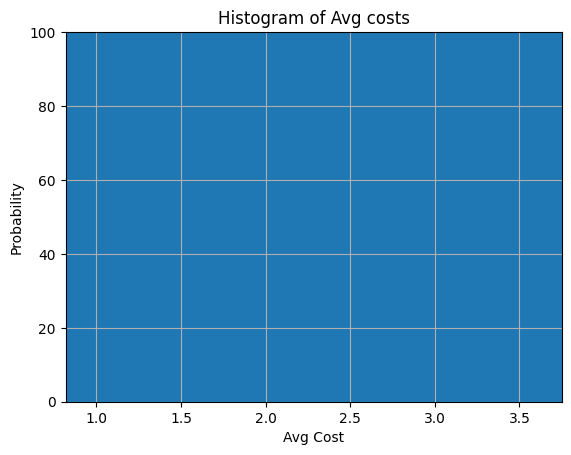

In [35]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_ss, bins=np.arange( np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [36]:
# import matplotlib.pyplot as plt

# costs, avg_cost_per_period = mc_episode_with_policy(sourcingEnv2, policy = ss_policy_fastest_supp_backlog, periods = 1000,
#     nested_mc_iters = 100,
#     policy_callback = ss_policy_fastest_supp_backlog,
#     big_s = model_params['policy_params']['big_s'],
#     small_s = model_params['policy_params']['small_s'],
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'],
#     use_tqdm = True)

# # costs
# plt.plot(costs)

In [37]:
single_supplier_mean_costs = []
sing_supp_mean_cost = np.Inf
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : 100,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    sing_supp_mean_cost_i = np.mean(single_supplier_costs)
    single_supplier_mean_costs.append(sing_supp_mean_cost_i)
    if sing_supp_mean_cost_i < sing_supp_mean_cost:
        single_supplier_costs_select = single_supplier_costs
        sing_supp_mean_cost = sing_supp_mean_cost_i

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

100%|██████████| 100/100 [00:06<00:00, 14.52it/s]

[4.657861395306205, 3.3412904911673484]
3.3412904911673484


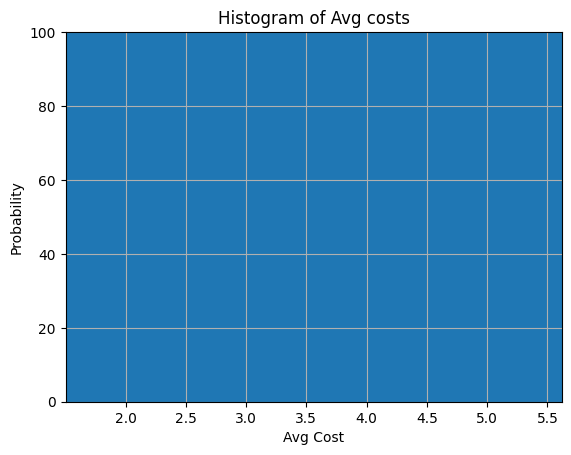

In [38]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(single_supplier_costs_select, bins=np.arange( np.min(single_supplier_costs_select), np.max(single_supplier_costs_select) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(single_supplier_costs_select), np.max(single_supplier_costs_select))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [39]:
from sim.dual_index_v1 import *
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy_v1,
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

100%|██████████| 30/30 [00:26<00:00,  1.15it/s]

2.31385188918029
2.1276315851398517
0.6015671993902457


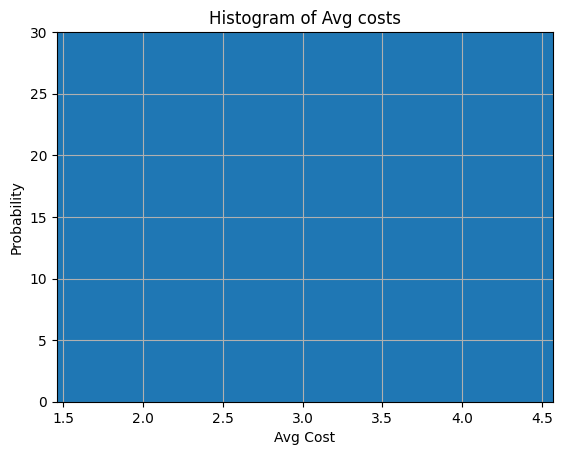

In [40]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [41]:
kwargs = {
    "value_dic": value_dic, 
    "periods": 100, 
    "periods_val_it": 1,
    "nested_mc_iters": 30,
    "max_stock": BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": 1.01, #SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True,
    "pol_dic": output_obj['pol_dic']
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_policy_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

100%|██████████| 30/30 [00:10<00:00,  2.79it/s]

3.160189374341598
2.7421726675320226
1.431795179605505


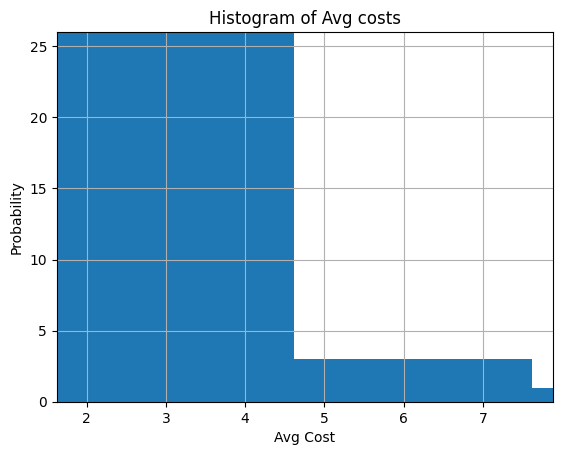

In [42]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs) - binwidth, np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [43]:
myopic_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 5,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 6, # BIG_S,
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_cost))
print(np.median(np.array(myopic_cost)))
print(np.std(np.array(myopic_cost)))

100%|██████████| 5/5 [01:47<00:00, 21.41s/it]

6.810094595860901
7.22172483677068
0.9119331134027938


In [44]:
myopic_cost

[7.472749738509224,
 5.007242732340815,
 7.22172483677068,
 7.304530291894223,
 7.044225379789566]

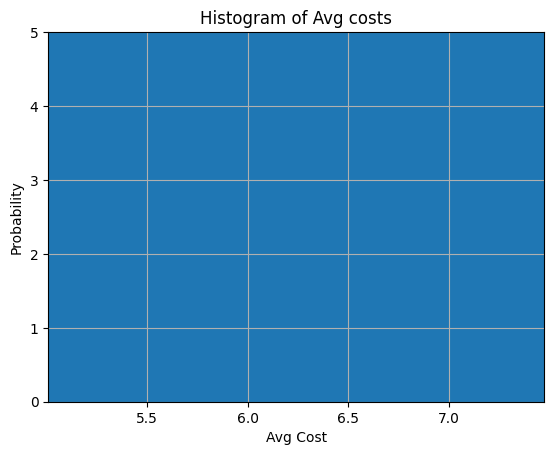

In [45]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(myopic_cost, bins=np.arange( np.min(myopic_cost), np.max(myopic_cost) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(myopic_cost), np.max(myopic_cost))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [46]:
# kwargs = {
#     "value_dic": value_dic, 
#     "periods": 100, 
#     "periods_val_it": 3,
#     "nested_mc_iters": 3,
#     "max_stock": 3, # BIG_S,
#     "discount_fac": DISCOUNT_FAC,
#     "h_cost": model_params['policy_params']['h_cost'],
#     "b_penalty": model_params['policy_params']['b_penalty'],
#     "n_visit_lim": N_VISIT_LIM,
#     "default_ss_policy": ss_policy_fastest_supp_backlog,
#     "safe_factor": 1.1, #SAFE_FACTOR,
#     "sub_eval_periods": SUB_EVAL_PERIODS,
#     "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
#     "approx_eval": True
# }

# mc_avg_costs = mc_with_policy(sourcingEnv2, 
#     start_state = s_custom, 
#     use_tqdm = True,
#     policy_callback = eval_policy_from_value_dic,
#     **kwargs)

# print(np.mean(mc_avg_costs))
# print(np.median(mc_avg_costs))
# print(np.std(mc_avg_costs))